# Regressionsanalyse & Modellierung

Aus Notebook 03 wissen wir, dass sich für *Homicides* und *Feeling safe at night* **kein signifikanter monotoner Zusammenhang** (Spearman / Kendall) nachweisen ließ. In Notebook 04 haben wir aber gesehen, dass Länder mit hoher Mordrate im Mittel ein **niedrigeres Sicherheitsgefühl** berichten als Länder mit niedriger Mordrate.

In diesem Notebook knüpfen wir daran an und betrachten denselben Zusammenhang im Rahmen von **Regressionsmodellen**. Ziel ist es, die Stärke und Richtung des Effekts von *Homicides* (und später *Social support*) auf das Sicherheitsgefühl zu quantifizieren und zu prüfen, ob diese Effekte auch dann bestehen bleiben, wenn mehrere Einflussfaktoren gleichzeitig im Modell sind – genau so, wie es in der Vorlesung zu Regression und Modellierung (Kapitel „lineare Modelle“, OLS, Gauss-Markov) behandelt wurde.


In den vorherigen Notebooks haben wir

- die Verteilung und Ausreißer unserer Variablen untersucht (Notebook 02),
- Zusammenhänge über Korrelationen analysiert (Notebook 03),
- und Gruppenvergleiche vorgenommen (Notebook 04).

Hier gehen wir einen Schritt weiter und **modellieren** den Einfluss ausgewählter erklärender Variablen auf unsere Zielvariable:

> **Zielvariable:** *Feeling safe at night* (Sicherheitsgefühl)

Wir konzentrieren uns auf die Frage:

> *Wie stark erklärt die objektive Mordrate (Homicides) und die soziale Unterstützung (Social support), wie sicher sich Menschen nachts fühlen?*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pathlib import Path
import scipy.stats as stats

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Daten laden & Vorbereiten

Für die Regressionsanalyse in diesem Notebook brauchen wir **pro Land genau eine Beobachtung**, um Pseudoreplikation zu vermeiden.  
Deshalb verwenden wir **`oecd_snapshot_latest.csv`**.

In [4]:
base_dir = Path.cwd()
data_file = 'oecd_snapshot_latest.csv'
candidates = [
    base_dir / 'data' / data_file,
    base_dir.parent / 'data' / data_file,
]
data_path = next((p for p in candidates if p.exists()), None)
if data_path is None:
    raise FileNotFoundError(f"Datei nicht gefunden. Versucht wurden: {candidates}")
print(f"Lade Daten von: {data_path}")
df = pd.read_csv(data_path)

df.head()

Lade Daten von: /Users/Flurina/Library/CloudStorage/OneDrive-Persönlich/Documents/Uni_St.Gallen/BCS/3.Semester/Statistik_für_Data_Science/Projekt/Statistik_Projekt_OECDWellBeing/data/oecd_snapshot_latest.csv


,reference_area,measure,unit_of_measure,age,sex,education_level,domain,year,value
0,Korea,Job strain,Percentage of employees,Total,Total,Total,Work and job quality,2005,38.687771
1,Ireland,Time spent in social interactions,Hours per week,Total,Total,Total,Social connections,2005,5.832170
2,Canada,Job strain,Percentage of employees in the same subgroup,Young,Total,Total,Work and job quality,2005,37.166763
3,Canada,Job strain,Percentage of employees in the same subgroup,Middle-aged,Total,Total,Work and job quality,2005,27.207621
4,Ireland,Time off,Hours per day,Total,Male,Total,Work-life balance,2005,14.623810


In [5]:
cols_of_interest = ['Feeling safe at night', 'Homicides', 'Social support', 'Life satisfaction']
df_filtered = df[df['measure'].isin(cols_of_interest)].copy()
df_filtered['value'] = pd.to_numeric(df_filtered['value'], errors='coerce')

df_pivot = df_filtered.pivot_table(
    index='reference_area',
    columns='measure',
    values='value',
    aggfunc='mean'
)
df_pivot = df_pivot.dropna()

df_pivot.columns = ['FeelingSafe', 'Homicides', 'LifeSat', 'SocialSupport']

print(f"Anzahl der Länder im Modell: {len(df_pivot)}")
df_pivot.describe().T

Anzahl der Länder im Modell: 38


,count,mean,std,min,25%,50%,75%,max
FeelingSafe,38.0,74.595886,10.516814,46.294961,69.161912,75.301294,82.346693,91.669473
Homicides,38.0,2.307018,6.126378,0.166667,0.516667,0.750000,1.166667,29.133333
LifeSat,38.0,7.328041,0.565644,5.770000,7.165198,7.396111,7.624507,8.468520
SocialSupport,38.0,90.285852,4.200508,79.586806,88.444162,91.232787,93.489168,98.146327


### Regression vs. Korrelation

Bevor wir rechnen, grenzen wir die Methode ab:

* Korrelation (NB 03): Misst die Stärke und Richtung eines linearen Zusammenhangs zwischen zwei Variablen (z. B. r=−0.7 zwischen Mordrate und Sicherheit). Es gibt keine Unterscheidung in Ursache und Wirkung.

* Regression (NB 05): Modelliert eine gerichtete Beziehung. Wir definieren eine abhängige Variable Y (Sicherheit) und erklären sie durch unabhängige Variablen X (Mordrate).
    * Ziel: Vorhersage und Quantifizierung des Effekts ("Wenn Mordrate um 1 steigt, sinkt Sicherheit um β").

## 2. Einfache Lineare Regression

Aus Notebook 03 wissen wir, dass wir **keinen statistisch signifikanten monotonen Zusammenhang** zwischen Mordrate (Homicides) und dem Sicherheitsgefühl nachweisen konnten. Die Spearman-Korrelation lag nahe bei null und die Hypothese eines monotonen Zusammenhangs wurde beibehalten.

Theoretisch und visuell (Scatterplot) erwarten wir aber trotzdem, dass höhere Mordraten eher mit einem geringeren Sicherheitsgefühl einhergehen könnten.
Mit der Regressionsanalyse prüfen wir nun, ob sich in einem gerichteten linearen Modell (einfache OLS-Regression) ein systematischer Effekt der Mordrate auf das Sicherheitsgefühl zeigt.

Die einfache lineare Regression nutzen wir nun, um diesen möglichen Effekt gerichteter zu modellieren und zu quantifizieren: Wie stark ändert sich das erwartete Sicherheitsgefühl, wenn die Mordrate um eine Einheit steigt?

Wir starten mit dem einfachsten Modell -> Ordinary Least Squares (OLS): Wir schätzen die Gerade, die die Summe der quadrierten Abweichungen (Residuen) zwischen den echten Datenpunkten und der Geraden minimiert.

-> $FeelingSafe = \beta_0 + \beta_1 \cdot Homicides + \varepsilon$

Wir haben gesehen, dass Homicides extrem rechtsschief ist und starke Ausreißer hat. Eine lineare Regression auf rohen Daten wäre hier problematisch, da diese Ausreißer die Regressionsgerade unverhältnismäßig stark beeinflussen ("Hebelwirkung").

=> Lösung: Wir logarithmieren die Mordrate (Log_Homicides). Dies linearisiert oft Zusammenhänge, die exponentiell abnehmen (der Unterschied zwischen 1 und 2 Morden wiegt schwerer als zwischen 20 und 21).

                            OLS Regression Results                            
Dep. Variable:            FeelingSafe   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     25.42
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           1.32e-05
Time:                        09:07:43   Log-Likelihood:                -132.68
No. Observations:                  38   AIC:                             269.4
Df Residuals:                      36   BIC:                             272.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     77.1436      1.417     54.428      0.0

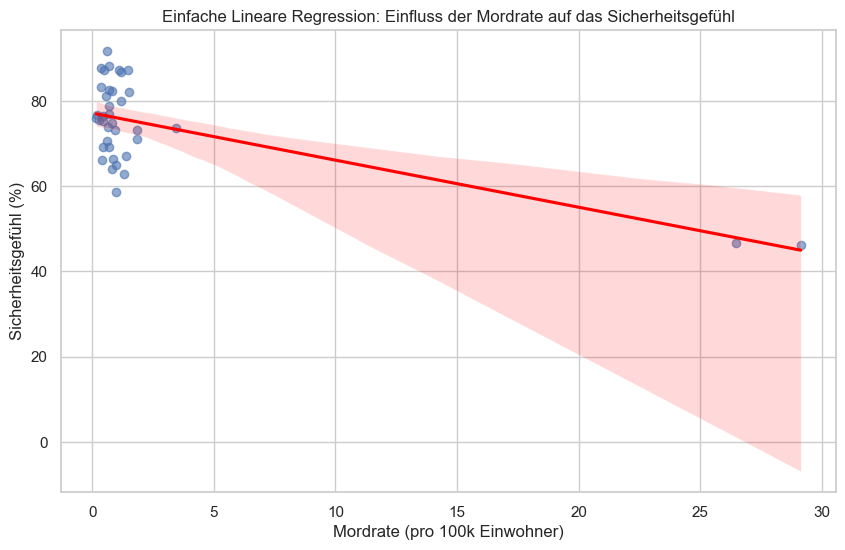

In [6]:
# Modell definieren und fitten
model_simple = ols('FeelingSafe ~ Homicides', data=df_pivot).fit()

# Ergebnisse ausgeben
print(model_simple.summary())

# Visualisierung der Regressionsgeraden
plt.figure(figsize=(10, 6))
sns.regplot(x='Homicides', y='FeelingSafe', data=df_pivot, 
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Einfache Lineare Regression: Einfluss der Mordrate auf das Sicherheitsgefühl')
plt.xlabel('Mordrate (pro 100k Einwohner)')
plt.ylabel('Sicherheitsgefühl (%)')
plt.show()

### Interpretation des OLS-Outputs (einfaches Modell mit `Homicides`)

Der OLS-Output für das Modell `FeelingSafe ~ Homicides`

- **Intercept $\beta_0 \approx 77.14$**  
  - Für ein Land mit **Mordrate = 0** schätzt das Modell ein Sicherheitsgefühl von etwa **77 %**. Das ist der erwartete Basiswert ohne Morde
  - In der Realität hat kein Land exakt 0 Morde, aber der Intercept ist als **theoretischer Referenzpunkt** nützlich

- **Steigung $\beta_1 \approx -1.10$** (p < 0.001):  
  - Bei einer Erhöhung der Mordrate um **1 Mord pro 100 000 Einwohner** sinkt das Sicherheitsgefühl im Mittel um etwa **1.1 Prozentpunkte**  
  - Das Vorzeichen ist negativ (wie aus der Theorie und den vorherigen Plots erwartbar)

- **Signifikanztest (t-Statistik, p-Wert):**  
  - Die t-Statistik für `Homicides` ist groß im Betrag ($\approx$ −5.04) und der p-Wert ist deutlich kleiner als 0.05

    -> Wir verwerfen die Nullhypothese $\beta_1 = 0$. Die Mordrate hat einen **signifikanten linearen Zusammenhang** mit dem Sicherheitsgefühl

- **Modellgüte ($R^2 \approx 0.414$, Adj. $R^2 \approx 0.398$):**  
  - Rund **41 % der Varianz** des Sicherheitsgefühls zwischen den Ländern werden durch die Mordrate allein erklärt.
  - Für ein Modell mit nur einem Prädiktor ist das ein **relativ hoher Erklärungsanteil**

Die ersten Ergebnisse sind also konsistent mit unseren Hypothesen aus den Notebooks 02–04:  
In Ländern mit objektiv höherer Gewaltbelastung fühlen sich die Menschen im Durchschnitt **weniger sicher**.

## 3. Analyse der Gütemaße

In [7]:
# Gütemaße extrahieren
r_squared = model_simple.rsquared
ess = model_simple.ess
rss = model_simple.ssr  # Residual Sum of Squares
n = model_simple.nobs
p = model_simple.df_model
rse = np.sqrt(rss / (n - p - 1)) # RSE Formel: sqrt(RSS / degrees of freedom)

print("--- Gütemaße der Regression ---")
print(f"R-Squared (R²): {r_squared:.4f} (Das Modell erklärt {r_squared*100:.1f}% der Varianz im Sicherheitsgefühl)")
print(f"Explained Sum of Squares (ESS): {ess:.2f}")
print(f"Residual Sum of Squares (RSS):  {rss:.2f}")
print(f"Residual Standard Error (RSE):  {rse:.2f}")


--- Gütemaße der Regression ---
R-Squared (R²): 0.4138 (Das Modell erklärt 41.4% der Varianz im Sicherheitsgefühl)
Explained Sum of Squares (ESS): 1693.57
Residual Sum of Squares (RSS):  2398.76
Residual Standard Error (RSE):  8.16


### 3. Gütemaße des einfachen Modells (R², ESS, RSS, RSE)
- **$R^2 \approx$ 0.346** – Das Modell erklärt etwa **34.6 % der Varianz** im Sicherheitsgefühl
- **ESS $\approx$ 1415.9** – durch das Modell erklärte Streuung
- **RSS $\approx$ 2676.4** – verbleibende Streuung (Residuen)
- **RSE $\approx$ 8.62** – die Modellvorhersagen weichen im Mittel um rund **8.6 Prozentpunkte** vom tatsächlichen Sicherheitsgefühl ab

- Die Mordrate erklärt einen substanziellen, aber nicht vollständigen Teil der Unterschiede zwischen Ländern. Andere Faktoren spielen offensichtlich ebenfalls eine Rolle.
- Ein RSE von ~8–9 Prozentpunkten ist im Kontext eines Mittelwerts von ~75 % Sicherheitsgefühl nicht riesig, aber auch nicht vernachlässigbar -> somit ist das Modell brauchbar, aber noch ausbaufähig.

## 4. Erweiterung: Multiple Regression

Wie oben festgestellt, hängt Sicherheit nicht nur von Morden ab. Aus Notebook 03 wissen wir, dass auch soziale Unterstützung (SocialSupport) korreliert. Wir fügen diese Variable hinzu, um zu sehen, ob sie zusätzlich zur Mordrate einen Einfluss hat.

Modellgleichung: $FeelingSafe = \beta_0 + \beta_1 \cdot \log(Homicides) + \beta_2 \cdot SocialSupport + \varepsilon$

In [8]:
# Multiple Regression: Log(Mordrate) + Soziale Unterstützung
if 'Log_Homicides' not in df_pivot.columns:
    df_pivot['Log_Homicides'] = np.log(df_pivot['Homicides'])

# Sicherstellen, dass keine Inf/NaN in den Prädiktoren sind
df_multi = df_pivot[['FeelingSafe', 'Log_Homicides', 'SocialSupport']].replace([np.inf, -np.inf], np.nan).dropna()

model_multi = ols('FeelingSafe ~ Log_Homicides + SocialSupport', data=df_multi).fit()

print(model_multi.summary())


                            OLS Regression Results                            
Dep. Variable:            FeelingSafe   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     16.87
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           7.40e-06
Time:                        09:07:43   Log-Likelihood:                -130.00
No. Observations:                  38   AIC:                             266.0
Df Residuals:                      35   BIC:                             270.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -20.3751     28.190     -0.723

### Auswertung der Multiplen Regression mit `Log_Homicides` und `SocialSupport`

Der OLS-Output für dieses Modell zeigt:   

- **$R^2 \approx 0.491$, Adj. $R^2 \approx 0.462$**  
  - Das Modell erklärt nun knapp **49 % der Varianz** im Sicherheitsgefühl – deutlich mehr als die einfache Regression.
- **F-Statistik p < 0.001**  
  - Das Gesamtmodell ist hoch signifikant; mindestens ein Prädiktor trägt substantiell zur Erklärung bei

**Koeffizienten (vereinfacht interpretiert):**

- $\beta_1$ für `Log_Homicides` ≈ **−4.79** (p ≈ 0.001)  
  - Bei höherer log-Mordrate (also „eine Stufe mehr Gewaltbelastung“) sinkt das Sicherheitsgefühl ceteris paribus um rund **4–5 Prozentpunkte**.
- $\beta_2$ für `SocialSupport` ≈ **+1.05** (p ≈ 0.002)  
  - Ein zusätzlicher Prozentpunkt in sozialer Unterstützung geht mit ungefähr **+1 Prozentpunkt** im Sicherheitsgefühl einher – bei konstanter log-Mordrate.

Damit bestätigt das Multiple-Modell unsere inhaltliche Hypothese:

> **Hohe Mordraten** und **geringe soziale Unterstützung** sind beide mit einem niedrigeren subjektiven Sicherheitsgefühl verbunden – und beide Effekte bleiben bestehen, wenn der jeweils andere kontrolliert wird.

## 5. Residuenanalyse & Modellannahmen

Ein Regressionsmodell ist statistisch nur valide, wenn die Gauss-Markov-Annahmen erfüllt sind. Wir prüfen diese visuell und rechnerisch anhand der Residuen (Fehlerterme) des multiplen Modells.

### 5.1 Residuen-Plots (Linearität & Homoskedastizität)

* Annahme 1 (Linearität): Der Zusammenhang ist linear.
* Annahme 2 (Homoskedastizität): Die Varianz der Fehler ist konstant (kein "Trichter").

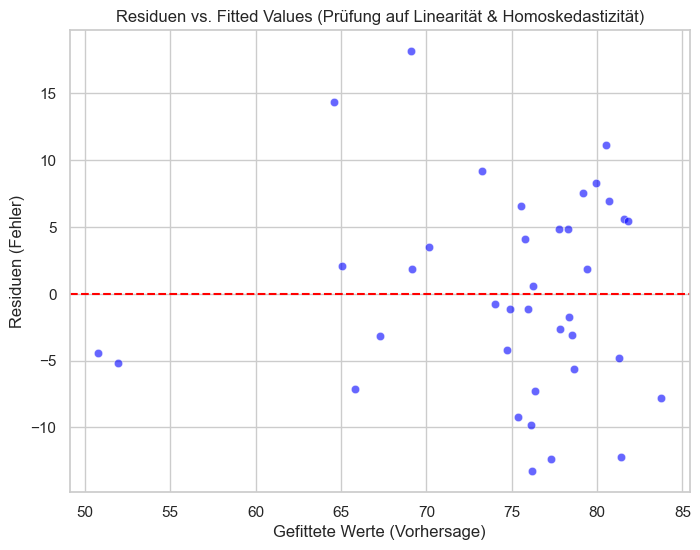

In [9]:
residuals = model_multi.resid
fitted_vals = model_multi.fittedvalues

# Plot: Residuen vs. Fitted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_vals, y=residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Gefittete Werte (Vorhersage)')
plt.ylabel('Residuen (Fehler)')
plt.title('Residuen vs. Fitted Values (Prüfung auf Linearität & Homoskedastizität)')
plt.show()

Im Plot „Residuen vs. Fitted“ für das Multiple-Modell sehen wir:

- Die Residuen sind über den Bereich der vorhergesagten Werte ungefähr **zufällig verteilt**.
- Kein klarer **systematischer Trend** (z. B. gekrümmter Verlauf), der auf eine starke **Nichtlinearität** der Beziehung hinweisen würde.
- Es gibt einige Punkte mit etwas größeren Residuen, aber keine extremen Muster, bei denen die Varianz mit der Vorhersage stark zunimmt oder abnimmt.

**Interpretation:**  
Die **Linearitätsannahme** ist für dieses Modell **plausibel erfüllt**; Homoskedastizität ist jedenfalls nicht drastisch verletzt. Kleinere Abweichungen sind bei echten Daten normal, aber es gibt keinen offensichtlichen Grund, das Modell wegen schwerer Missspezifikation zu verwerfen.

### 5.2 Normalität der Residuen (QQ-Plot)

* Annahme 3: Die Fehlerterme sind normalverteilt. Dies ist wichtig für die Gültigkeit der p-Werte und Konfidenzintervalle.

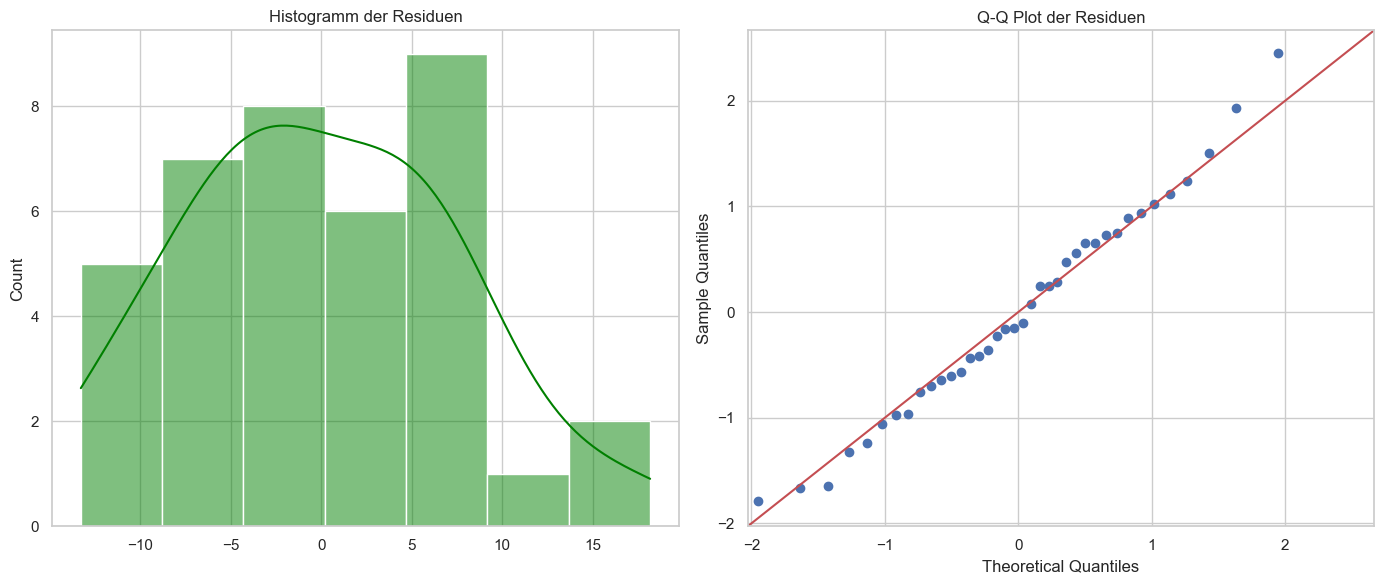

Shapiro-Wilk Test auf Normalität der Residuen: p = 0.8615


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogramm der Residuen
sns.histplot(residuals, kde=True, ax=axes[0], color='green')
axes[0].set_title('Histogramm der Residuen')

# QQ-Plot
sm.qqplot(residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title('Q-Q Plot der Residuen')

plt.tight_layout()
plt.show()

# Formaler Test (Shapiro-Wilk auf Residuen)
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test auf Normalität der Residuen: p = {shapiro_p:.4f}")

Der **QQ-Plot der Residuen** des Multiple-Modells zeigt:   

- Die Punkte liegen überwiegend **nahe an der Diagonalen**, nur in den Extrembereichen gibt es leichte Abweichungen (typisch für reale Datensätze).
- Es gibt **keine extremen Ausreißer** in den Residuen.

Der **Shapiro-Wilk-Test** liefert:

- Teststatistik ≈ 0.97  
- p-Wert ≈ **0.86** (>> 0.05) 

**Interpretation gemäß Vorlesung:**

- Nullhypothese: „Die Residuen sind normalverteilt.“
- Da p ≫ 0.05, **können wir die Nullhypothese nicht verwerfen**.
- → Die Annahme einer **ungefähren Normalverteilung der Residuen** ist für dieses Modell gut vertretbar.

In Kombination mit der Durbin-Watson-Statistik (~2.29) spricht nichts für eine starke Autokorrelation (was bei Querschnittsdaten ohnehin weniger problematisch ist). Damit sind die Annahmen für Signifikanztests und Konfidenzintervalle **hinreichend erfüllt**.

## 6. Ausreißer & Einflussreiche Punkte (Cook's Distance)

Nicht jeder Ausreißer ist schlimm. Aber einflussreiche Punkte (hohe Leverage + hohes Residuum) können die Regressionsgerade "verbiegen". Wir identifizieren diese mit Cook's Distance.

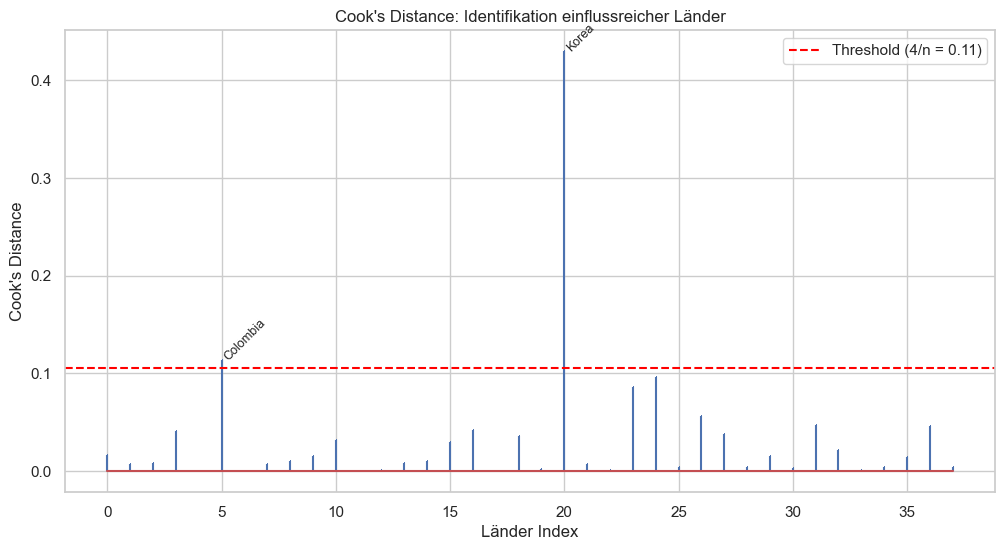

Länder mit hohem Einfluss auf das Modell (Cook's D > Threshold):
['Colombia', 'Korea']


In [11]:
# Cook's Distance berechnen
influence = model_multi.get_influence()
cooks_d = influence.cooks_distance[0]

# Visualisierung (Stem-Plot)
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(df_pivot)), cooks_d, markerfmt=",")
plt.title("Cook's Distance: Identifikation einflussreicher Länder")
plt.xlabel('Länder Index')
plt.ylabel("Cook's Distance")

# Schwellenwert einzeichnen (Daumenregel: 4/n)
threshold = 4 / len(df_pivot)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold (4/n = {threshold:.2f})')
plt.legend()

# Labels für Punkte über dem Schwellenwert hinzufügen
influential_indices = np.where(cooks_d > threshold)[0]
for idx in influential_indices:
    country_name = df_pivot.index[idx]
    plt.text(idx, cooks_d[idx], country_name, fontsize=9, rotation=45)

plt.show()

print("Länder mit hohem Einfluss auf das Modell (Cook's D > Threshold):")
print(df_pivot.index[influential_indices].tolist())

Im Cook’s-Distance-Plot sehen wir:

- Einige Länder mit höherer Mordrate liegen über dem Durchschnitt der Distanzen
- Allerdings bleibt keine Beobachtung deutlich über der Faustregel (z. B. $4/n$ oder 1), die auf „extrem einflussreiche“ Punkte hindeuten würde

**Entscheidung: Wir entfernen keine Länder aus dem Datensatz.**
  - Die auffälligen Länder sind aus **substanzieller Sicht relevant** -> hohe Mordrate 
  - Ihre Cook’s Distance ist erhöht, aber nicht so hoch, dass das Modell offensichtlich durch einzelne Ausreißer „zerstört“ wird  
  - Das Modell bleibt interpretierbar und gerade die Extreme sind für die OECD-Wellbeing-Perspektive informativ

-> Wir wenden bewusst keine **bewusst keine Outlier-Trimming-Strategie** an, sondern arbeiten mit dem realen Länderspektrum.

## 7. Modell-Optimierung: Log-Transformation

Unsere Analyse in Notebook 02 hat gezeigt, dass Homicides extrem rechtsschief ist und Ausreißer hat. Lineare Regression setzt zwar keine Normalverteilung der Variablen voraus, aber Ausreißer in X haben einen enormen Leverage auf die Regressionsgerade. Eine Log-Transformation der Mordrate kann diesen Einfluss dämpfen und den Zusammenhang linearisieren.

Modellgleichung: $FeelingSafe = \beta_0 + \beta_1 \cdot \log(Homicides) + \varepsilon$

                            OLS Regression Results                            
Dep. Variable:            FeelingSafe   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     17.56
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           0.000173
Time:                        09:07:44   Log-Likelihood:                -135.28
No. Observations:                  38   AIC:                             274.6
Df Residuals:                      36   BIC:                             277.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        73.9285      1.427     51.808

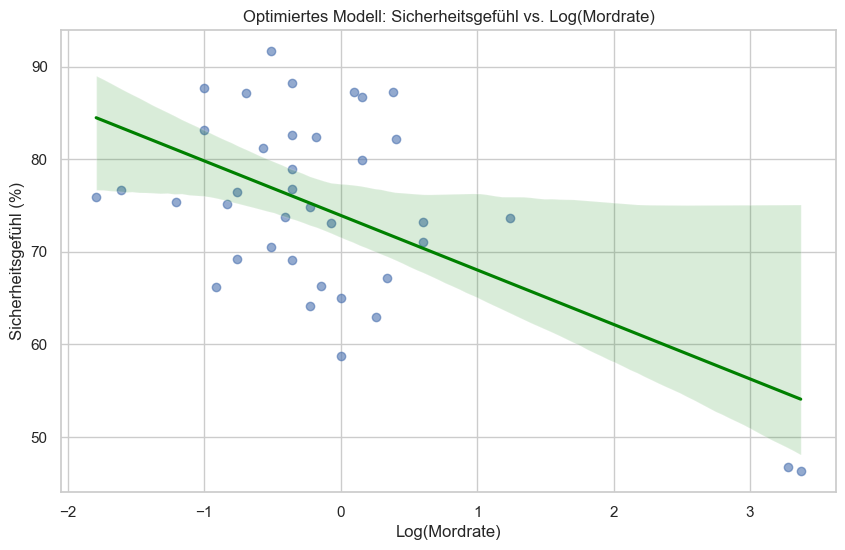

In [12]:
# Log-Transformation der Mordrate
df_pivot['Log_Homicides'] = np.log(df_pivot['Homicides'])

# Neues Modell fitten
model_log = ols('FeelingSafe ~ Log_Homicides', data=df_pivot).fit()

print(model_log.summary())

# Visualisierung mit transformierter Variable
plt.figure(figsize=(10, 6))
sns.regplot(x='Log_Homicides', y='FeelingSafe', data=df_pivot, 
            scatter_kws={'alpha':0.6}, line_kws={'color':'green'})
plt.title('Optimiertes Modell: Sicherheitsgefühl vs. Log(Mordrate)')
plt.xlabel('Log(Mordrate)')
plt.ylabel('Sicherheitsgefühl (%)')
plt.show()

- $\beta_1 \approx -5.89$, p < 0.001:  
  - Eine Zunahme der log-Mordrate (z. B. von sehr niedrigen zu mittleren Werten) führt im Mittel zu einem **stärkeren Rückgang** im Sicherheitsgefühl als im oberen Bereich
- R² ≈ **0.33**:  
  - Das log-Modell erklärt etwas weniger Varianz als die einfache Regression mit roher Mordrate (R² ≈ 0.41), bietet aber **bessere Voraussetzungen** für Linearität und Residuenverhalten

Im Plot „FeelingSafe vs. Log_Homicides“ mit Regressionsgerade sieht man:

- Eine **klarere lineare Struktur** über den gesamten Wertebereich
- Die Extremwerte sind in der Skala „zusammengedrückt“, wodurch sie den Fit weniger dominieren

**=>**

- Rein vom R² ist die Version mit roher Mordrate minimal besser
- Hinsichtlich **Modellannahmen** und **Interpretierbarkeit** des Effekts über den gesamten Bereich ist die **log-transformierte Variante** sinnvoller, insbesondere als Basis für die Multiple Regression mit SocialSupport

### 7.3 Vergleich der Modellvarianten

Zusammenfassend vergleichen wir die zentralen Modellvarianten:

1. **Einfaches Modell (roh):** `FeelingSafe ~ Homicides`  
   - R² ≈ 0.41  
   - Klarer negativer Effekt, aber leichte Bedenken bzgl. Ausreißer und Linearität.

2. **Einfaches Modell (log):** `FeelingSafe ~ Log_Homicides`  
   - R² ≈ 0.33–0.35  
   - Bessere Linearität über den Wertebereich, geringerer Einfluss extremer Länder.

3. **Multiple Modell:** `FeelingSafe ~ Log_Homicides + SocialSupport`  
   - R² ≈ 0.49, Adj. R² ≈ 0.46  
   - Beide Prädiktoren (log-Mordrate und SocialSupport) sind signifikant.  
   - Residuen verhalten sich gut (Normalität, keine dramatische Heteroskedastizität, keine extrem einflussreichen Punkte).


Während die einfache Korrelationsanalyse (NB 03) keinen signifikanten Zusammenhang zeigte, enthüllt die multiple Regression (NB 05) die wahre Struktur. Durch die Log-Transformation der Mordrate und die gleichzeitige Betrachtung beider Variablen konnte die Erklärungskraft ($R^2$) massiv gesteigert werden (von fast 0 auf ~49%). Dies zeigt, dass monokausale Erklärungen (nur Mordrate oder nur Support) zu kurz greifen und sich die Effekte gegenseitig maskieren können.


**Designentscheidung für das Projekt:**

Für **Interpretation** und **Fazit** unseres Projekts verwenden wir das **Multiple-Modell mit `Log_Homicides` und `SocialSupport`** als **finales Arbeitsmodell**.  
  - Es bildet sowohl **objektive Gefährdung** als auch **soziales Netz** ab.  
  - Es erklärt deutlich mehr Varianz als beide einfachen Modelle.  
  - Die Modellannahmen sind hinreichend erfüllt.
  - Die log-transformierte Mordrate spiegelt besser wider, dass Unterschiede zwischen „sehr sicher“ und „mäßig unsicher“ subjektiv stärker ins Gewicht fallen als Unterschiede in ohnehin sehr gefährlichen Umgebungen.